In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model, load_model

import tensorflow as tf

import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt




In [2]:
# load the pre-trained CNN from disk
model = load_model("breast_cancer_inception2.keras", compile=False)

In [91]:
# load the original image from disk (in OpenCV format) and then
# resize the image to its target dimensions
orig = cv2.imread("gradCAM/M New/m27.jpg")
#orig = cv2.imread("split_data/train/M/M (1).jpeg")
resized = cv2.resize(orig, (224, 224))

In [92]:
# load the input image from disk (in Keras/TensorFlow format) and
# preprocess it
img_path = "gradCAM/M New/m27.jpg"
#img_path = 'split_data/train/M/M (1).jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0

In [93]:
# use the network to make predictions on the input imag and find
# the class label index with the largest corresponding probability
preds = model.predict(img_array)
i = np.argmax(preds[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [94]:
# decode the ImageNet predictions to obtain the human-readable label
label = 'Malignant' if preds[0] > 0.5 else 'Benign'
label = "{}".format(label)
print("[INFO] {}".format(label))

[INFO] Malignant


In [95]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_JET):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [96]:
# initialize our gradient class activation map and build the heatmap
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(img_array)

In [97]:
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

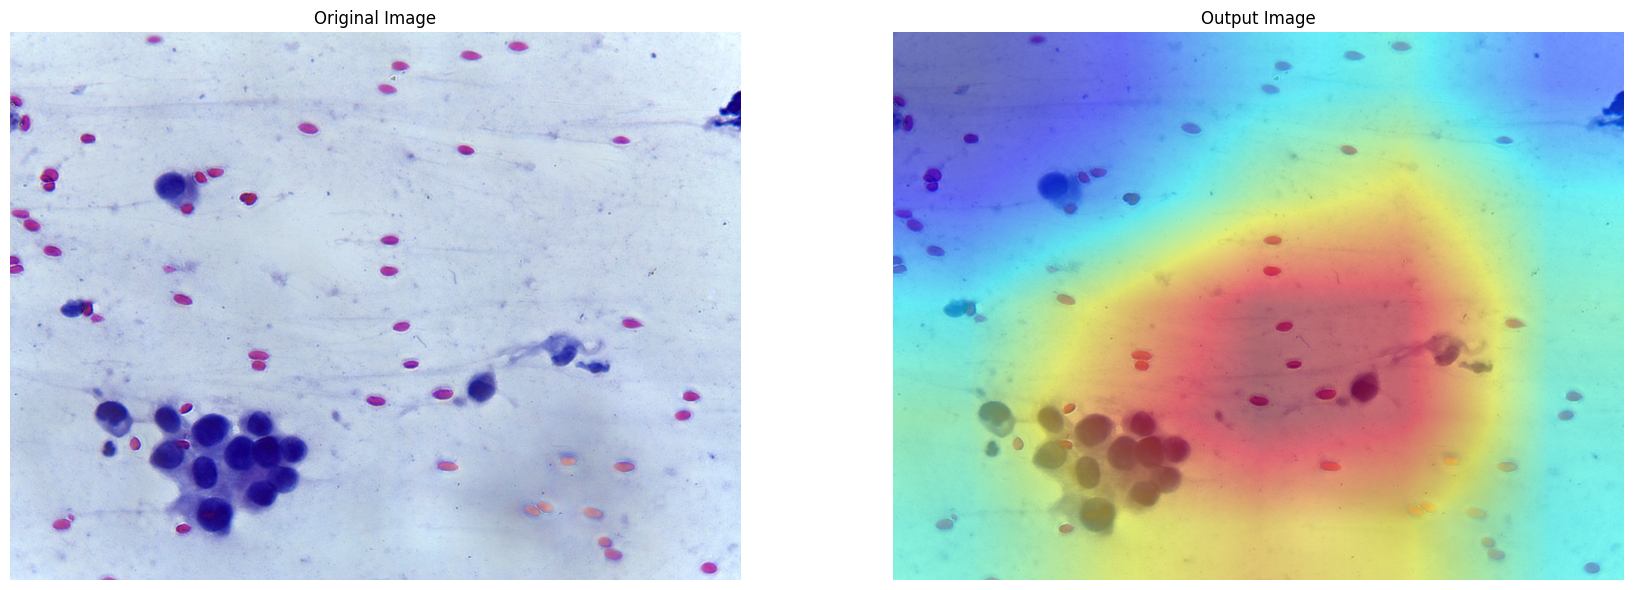

In [98]:
heatmap_image_path = "heatmap.jpg"
cv2.imwrite(heatmap_image_path, heatmap)

#output_image_path = "output_image.jpg"
#cv2.imwrite(output_image_path, output)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Original Image
axes[0].imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis("off")

# Heatmap
# axes[1].imshow(heatmap, cmap='jet')  # Use a colormap if heatmap is grayscale
# axes[1].set_title("Heatmap")
# axes[1].axis("off")

# Output Image (blended)
output_image = cv2.addWeighted(orig, 0.5, heatmap, 0.5, 0)
axes[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
axes[1].set_title("Output Image")
axes[1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()